## Setup

In [1]:
!nvidia-smi

Sun Apr 25 05:37:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Let's start with importing TF-2 and all relevant dependencies.

In [2]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.test.is_gpu_available())

TF Version:  2.4.1
TF-Hub version:  0.12.0
Eager mode enabled:  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available:  True


In [3]:
def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = plt.imread(image_path).astype(np.float32)[np.newaxis, ...]
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w  * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()


## Import TF-Hub module

In [4]:
# Load TF-Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

The signature of this hub module for image stylization is:
```
outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]
```
Where `content_image`, `style_image`, and `stylized_image` are expected to be 4-D Tensors with shapes `[batch_size, image_height, image_width, 3]`.

In the current example we provide only single images and therefore the batch dimension is 1, but one can use the same module to process more images at the same time.

The input and output values of the images should be in the range [0, 1].

The shapes of content and style image don't have to match. Output image shape
is the same as the content image shape.

## Let's try it face images

In [5]:
content_urls = dict(
  adele= "https://i.pinimg.com/originals/60/ae/fc/60aefc6132c9c0033f5fab7fd9c154cc.jpg",
  alice_eve ="https://i.pinimg.com/736x/28/00/d4/2800d4d1e7395a3cfe7350b9c719afb2.jpg",
  andy_garcia="https://i.pinimg.com/736x/3c/05/b2/3c05b2b0d6ba5da4612d2e975d2c0d56--gray-eyes-brown-eyes.jpg",
  amber_heard ="https://www.beautycrew.com.au/media/10960/amber-heard-portrait.jpg",
  albert_finney="https://www.thewrap.com/wp-content/uploads/2019/02/albert.jpg",
  alec_baldwin="https://the-hollywood-gossip-res.cloudinary.com/iu/s--AqPmQZci--/t_xlarge_p/cs_srgb,f_auto,fl_strip_profile.lossy,q_auto:420/v1541184008/alec-baldwin-looks-gruff.jpg",
  alex_pettyfer="https://media.glamour.com/photos/5695ae93d9dab9ff41b3a25e/master/w_400,h_615,c_limit/sex-love-life-blogs-smitten-0304_alex%20pettyfer.jpg",
  adriana_lima= "https://i.pinimg.com/564x/55/34/39/553439661b4b14d8d1b9a9a132d27236.jpg",
  abigail_breslin="https://assets.mycast.io/actor_images/actor-abigail-breslin-35107_large.jpg?1580367788",
  alexandra_daddario="https://www2.pictures.zimbio.com/gi/Alexandra+Daddario+MBFW+Front+Row+Peter+Som+lu0VhGTDYpSx.jpg",
  ali_larter="https://i.pinimg.com/originals/98/71/ba/9871bafa5348108463f89f01dc51e373.jpg",
  andrew_garfield="https://hairstyles.thehairstyler.com/hairstyle_views/front_view_images/9355/original/Andrew-Garfield.jpg",
  audrey_hepburn="https://theperfecthumanface.files.wordpress.com/2019/12/perfect-human-face-15.jpg",
  ashton_kutcher="https://pinkmirror.com/Data_Store/person/Ashton%20Kutcher/191069.jpg"
  )
style_urls = dict(
  kanagawa_great_wave='https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg',
  kandinsky_composition_7='https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg',
  hubble_pillars_of_creation='https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg',
  van_gogh_starry_night='https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg',
  turner_nantes='https://upload.wikimedia.org/wikipedia/commons/b/b7/JMW_Turner_-_Nantes_from_the_Ile_Feydeau.jpg',
  munch_scream='https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg',
  picasso_demoiselles_avignon='https://upload.wikimedia.org/wikipedia/en/4/4c/Les_Demoiselles_d%27Avignon.jpg',
  picasso_violin='https://upload.wikimedia.org/wikipedia/en/3/3c/Pablo_Picasso%2C_1911-12%2C_Violon_%28Violin%29%2C_oil_on_canvas%2C_Kr%C3%B6ller-M%C3%BCller_Museum%2C_Otterlo%2C_Netherlands.jpg',
  picasso_bottle_of_rum='https://upload.wikimedia.org/wikipedia/en/7/7f/Pablo_Picasso%2C_1911%2C_Still_Life_with_a_Bottle_of_Rum%2C_oil_on_canvas%2C_61.3_x_50.5_cm%2C_Metropolitan_Museum_of_Art%2C_New_York.jpg',
  fire='https://upload.wikimedia.org/wikipedia/commons/3/36/Large_bonfire.jpg',
  derkovits_woman_head='https://upload.wikimedia.org/wikipedia/commons/0/0d/Derkovits_Gyula_Woman_head_1922.jpg',
  amadeo_style_life='https://upload.wikimedia.org/wikipedia/commons/8/8e/Untitled_%28Still_life%29_%281913%29_-_Amadeo_Souza-Cardoso_%281887-1918%29_%2817385824283%29.jpg',
  derkovtis_talig='https://upload.wikimedia.org/wikipedia/commons/3/37/Derkovits_Gyula_Talig%C3%A1s_1920.jpg',
  amadeo_cardoso='https://upload.wikimedia.org/wikipedia/commons/7/7d/Amadeo_de_Souza-Cardoso%2C_1915_-_Landscape_with_black_figure.jpg'
)

content_image_size = 256
style_image_size = 256
content_images = {k: load_image(v, (content_image_size, content_image_size)) for k, v in content_urls.items()}
style_images = {k: load_image(v, (style_image_size, style_image_size)) for k, v in style_urls.items()}
style_images = {k: tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME') for k, style_image in style_images.items()}


In [6]:
style_images.keys()

dict_keys(['kanagawa_great_wave', 'kandinsky_composition_7', 'hubble_pillars_of_creation', 'van_gogh_starry_night', 'turner_nantes', 'munch_scream', 'picasso_demoiselles_avignon', 'picasso_violin', 'picasso_bottle_of_rum', 'fire', 'derkovits_woman_head', 'amadeo_style_life', 'derkovtis_talig', 'amadeo_cardoso'])

In [7]:
content_images.keys()

dict_keys(['adele', 'alice_eve', 'andy_garcia', 'amber_heard', 'albert_finney', 'alec_baldwin', 'alex_pettyfer', 'adriana_lima', 'abigail_breslin', 'alexandra_daddario', 'ali_larter', 'andrew_garfield', 'audrey_hepburn', 'ashton_kutcher'])

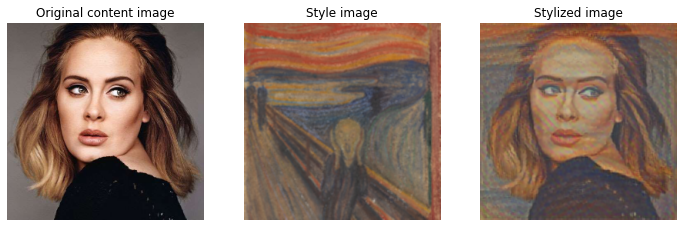

In [8]:
content_name = 'adele'  # ['adele', 'alice_eve', 'andy_garcia', 'amber_heard', 'albert_finney', 'alec_baldwin', 'alex_pettyfer', 'adriana_lima', 'abigail_breslin', 'alexandra_daddario', 'ali_larter', 'andrew_garfield', 'audrey_hepburn', 'ashton_kutcher']
style_name = 'munch_scream'  # ['kanagawa_great_wave', 'kandinsky_composition_7', 'hubble_pillars_of_creation', 'van_gogh_starry_night', 'turner_nantes', 'munch_scream', 'picasso_demoiselles_avignon', 'picasso_violin', 'picasso_bottle_of_rum', 'fire', 'derkovits_woman_head', 'amadeo_style_life', 'derkovtis_talig', 'amadeo_cardoso']

stylized_image = hub_module(tf.constant(content_images[content_name]),
                            tf.constant(style_images[style_name]))[0]

show_n([content_images[content_name], style_images[style_name], stylized_image],
       titles=['Original content image', 'Style image', 'Stylized image'])

## Compare loss

In [9]:
from tensorflow.keras.applications import vgg19
from keras.utils import plot_model
from keras import Model

model = vgg19.VGG19(weights="imagenet", include_top=False)

In [10]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [11]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = 256 * 256
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [12]:
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

In [13]:
from keras import Model

outputs_dict= dict([(layer.name, layer.output) for layer in model.layers])

feature_extractor = Model(inputs=model.inputs, outputs=outputs_dict)

In [14]:
style_layers = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

content_layers = "block5_conv2"

content_weight = 1e-3
style_weight = 1

In [17]:
def loss_function(combination_image, base_image, style_reference_image):

    # 1. Combine all the images in the same tensioner.
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )

    # 2. Get the values in all the layers for the three images.
    features = feature_extractor(input_tensor)

    #3. Inicializar the loss
    loss_content = tf.zeros(shape=())
    loss_style = tf.zeros(shape=())

    # 4. Extract the content layers + content loss
    layer_features = features[content_layers]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]

    loss_content = loss_content + content_weight*content_loss(
        base_image_features, combination_features
    )
    # 5. Extraer the style layers + style loss
    for layer_name in style_layers:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss_style += style_weight* sl / len(style_layers)
    # print("content loss: {}, style loss: {}".format(loss_content.numpy(),loss_style.numpy()))

    return (loss_content.numpy()+loss_style.numpy())/2

In [16]:
loss_function(stylized_image, content_images[content_name], style_images[style_name])

content loss: 73.30131530761719, style loss: 82.9866943359375


78.14400482177734

## Transfer on CelebA

In [18]:
import os
import random

In [19]:
def load_image_local(image_path, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = plt.imread(image_path).astype(np.float32)[np.newaxis, ...]
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

In [20]:
# mount my Google Drive directory and access the training data located there
from google.colab import drive
gdrive_dir = '/content/gdrive/'
drive.mount(gdrive_dir, force_remount=True)

Mounted at /content/gdrive/


In [21]:
%cd gdrive/MyDrive/cs585/

/content/gdrive/MyDrive/cs585


In [22]:
root = "./img_align_celeba/"
image_files = [root + file for file in os.listdir(root)]

In [23]:
len(image_files)

60584

In [32]:
image_files_sample = random.sample(image_files,1000)

In [33]:
len(image_files_sample)

1000

In [34]:
styles = ['kanagawa_great_wave', 'kandinsky_composition_7', 'hubble_pillars_of_creation', 'van_gogh_starry_night', 'turner_nantes', 'munch_scream', 'picasso_demoiselles_avignon', 'picasso_violin', 'picasso_bottle_of_rum', 'fire', 'derkovits_woman_head', 'amadeo_style_life', 'derkovtis_talig', 'amadeo_cardoso']

In [35]:
len(styles)

14

In [42]:
style2loss = {}
stime = time.time()
for i in range(len(styles)):
    print("process style: {}".format(styles[i]))
    single_style_loss = []
    for j in range(len(image_files_sample)):
        style_image = style_images[styles[i]]
        content_image = load_image_local(image_files_sample[j])

        stylized_image = hub_module(tf.constant(content_image),
                                    tf.constant(style_image))[0]
        loss = loss_function(stylized_image, content_image, style_image)
        single_style_loss.append(loss)
        if j % 100 == 0:
            print("processing image {}, cost time: {}".format(j,time.time()-stime))
    style2loss[styles[i]] = np.mean(single_style_loss)

process style: kanagawa_great_wave
processing image 0, cost time: 0.06382584571838379
processing image 100, cost time: 5.5728044509887695
processing image 200, cost time: 10.967927694320679
processing image 300, cost time: 16.359952688217163
processing image 400, cost time: 21.701385498046875
processing image 500, cost time: 27.095576286315918
processing image 600, cost time: 32.45278334617615
processing image 700, cost time: 37.87578058242798
processing image 800, cost time: 43.265098571777344
processing image 900, cost time: 101.93680739402771
process style: kandinsky_composition_7
processing image 0, cost time: 171.19085335731506
processing image 100, cost time: 176.60839819908142
processing image 200, cost time: 181.9637532234192
processing image 300, cost time: 187.2918210029602
processing image 400, cost time: 192.70475602149963
processing image 500, cost time: 198.08111763000488
processing image 600, cost time: 203.50750970840454
processing image 700, cost time: 208.890610456466

In [43]:
style2loss

{'amadeo_cardoso': 157.3727112045288,
 'amadeo_style_life': 116.97124618530273,
 'derkovits_woman_head': 68.93713648605346,
 'derkovtis_talig': 90.46098329544067,
 'fire': 139.78047351074218,
 'hubble_pillars_of_creation': 198.56337448883056,
 'kanagawa_great_wave': 293.18301263427736,
 'kandinsky_composition_7': 214.31390921020508,
 'munch_scream': 67.37230872726441,
 'picasso_bottle_of_rum': 91.18037514495849,
 'picasso_demoiselles_avignon': 108.47679708099365,
 'picasso_violin': 157.75619219207763,
 'turner_nantes': 137.770413772583,
 'van_gogh_starry_night': 91.20592498397828}